In [1]:
import csv
import os
from typing import List, AnyStr

import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
def merge_arg_sort(value: np.ndarray) -> np.ndarray:

    n = len(value)
    index_temp = np.zeros((n,), np.int32)
    index = np.arange(n)

    h = 1
    status = 0
    while h <= n:
        for j in range(0, n - h, 2 * h):
            ls = j
            le = j + h - 1
            rs = j + h
            re = j + 2 * h - 1 if j + 2 * h - 1 < n - 1 else n - 1
            index_temp[ls:re + 1] = index[ls:re + 1]
            i1 = ls
            j1 = rs
            for k in range(ls, re + 1):

                if i1 <= le and j1 <= re:
                    if value[index_temp[j1]] == value[index_temp[i1]]: status = 0
                    if value[index_temp[j1]] < value[index_temp[i1]]: status = -1
                    if value[index_temp[j1]] > value[index_temp[i1]]: status = 1
                else:
                    if i1 > le: status = -1
                    if j1 > re: status = 1

                if status >= 0:
                    index[k] = index_temp[i1]
                    i1 += 1
                else:
                    index[k] = index_temp[j1]
                    j1 += 1
        h *= 2
    return index

In [3]:
def coincident(max_coincident=1):
    def coincident_decorator(func):
        def wrapper(*args, **kwargs):
            coincident_num = 1
            extreme = func(*args, **kwargs)
            while coincident_num < max_coincident:
                kwargs['eps'] += 1
                recalculated_extreme = func(*args, **kwargs)
                if len(extreme) == len(recalculated_extreme):
                    coincident_num += 1
                else:
                    extreme = recalculated_extreme
                    coincident_num = 1
            return extreme, kwargs['eps']

        return wrapper

    return coincident_decorator

In [4]:
@coincident(1)
def extremal_min(*, index: np.ndarray, eps: int) -> np.ndarray:
    n, extreme_min = len(index), []
    for k in range(n):
        for l in range(1, k + 1):
            if abs(index[k] - index[k - l]) <= eps:
                break
        else:
            extreme_min.append(index[k])
    return extreme_min

In [5]:
@coincident(1)
def extremal_max(*, index: np.ndarray, eps: int) -> np.ndarray:
    n, extreme_max = len(index), []
    for k in range(n):
        for l in range(1, (n - k)):
            if abs(index[k] - index[k + l]) <= eps:
                break
        else:
            extreme_max.append(index[k])
    return extreme_max

In [6]:
def plot_res(values, color_min=None, extreme_min=None, e_min=None, color_max=None, extreme_max=None, e_max=None):
    plt.figure(figsize=(15, 9))
    plt.plot(values)
    if extreme_min is not None:
        plt.scatter(extreme_min, values[extreme_min], marker='o', color=color_min, s=150,
                    label=f'eps={e_min}, elem={len(extreme_min)}')

    if extreme_max is not None:
        plt.scatter(extreme_max, values[extreme_max], marker='o', color=color_max, s=150,
                    label=f'eps={e_max}, elem={len(extreme_max)}')
    plt.legend()
    plt.show()

In [7]:
path = "/Users/aleksandrturilin/HomeProject/echocardiography/data_training/training-b/b0017.wav"
y, sr = librosa.load(path, mono=True, duration=5)

print(f'Тип y: {type(y)} sr: {type(sr)}')
print(f'Размер аудиофайла: {y.shape}, {sr}')
print(f'Переменные: {y}, {sr}')

print(f'Аудио: {y}')

Тип y: <class 'numpy.ndarray'> sr: <class 'int'>
Размер аудиофайла: (110250,), 22050
Переменные: [-0.01280288 -0.01648721 -0.01988681 ... -0.01053306 -0.00694443
 -0.00370783], 22050
Аудио: [-0.01280288 -0.01648721 -0.01988681 ... -0.01053306 -0.00694443
 -0.00370783]


In [8]:
data = y[:]

[46694, 106508, 66465, 8282, 52527, 24432, 74604, 95526, 28464, 58040, 86611, 19240, 41349, 35032, 3634, 79626]
[0, 40541, 23485, 53224, 16735, 78542, 7006, 91430, 27595, 47588, 107849, 31107, 85532, 65112]


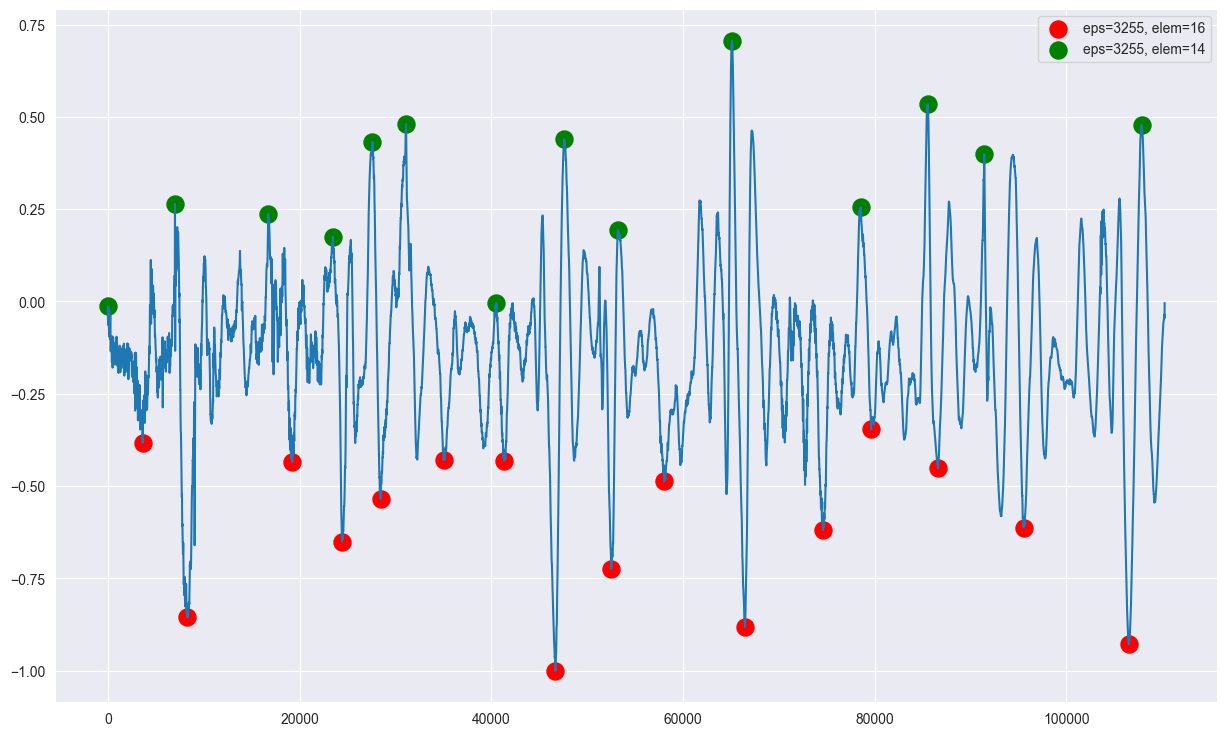

CPU times: user 1.64 s, sys: 1.17 s, total: 2.81 s
Wall time: 1.42 s


In [9]:
%%time
indexes = np.argsort(data, kind='mergesort')
indexes_min, eps_min = extremal_min(index=indexes, eps=3255)
indexes_max, eps_max = extremal_max(index=indexes, eps=3255)
print(indexes_min)
print(indexes_max)
plot_res(values=data, color_min='r', extreme_min=indexes_min, e_min=eps_min, color_max='g', extreme_max=indexes_max,
         e_max=eps_max)

In [10]:
# parse normal and abnormal audio file path
def parse_audio_path(training_dir: str, syb_dir: str) -> List[AnyStr]:
    with open(f'{training_dir}/{syb_dir}/RECORDS-normal', 'r') as file_normal:
        normal = file_normal.read().strip().split('\n')
        normal = list(map(lambda elem: f'{elem.strip()}.wav/1', normal))

    with open(f'{training_dir}/{syb_dir}/RECORDS-abnormal', 'r') as file_abnormal:
        abnormal = file_abnormal.read().strip().split('\n')
        abnormal = list(map(lambda elem: f'{elem.strip()}.wav/0', abnormal))

    return normal + abnormal

In [11]:
def create_header(num_min_elem: int, num_max_elem: int):
    return [
        'filename',
        *[f'extreme_min{i}' for i in range(num_min_elem)],
        *[f'extreme_max{i}' for i in range(num_max_elem)],
        'label',
    ]

In [12]:
def extract_features(training_dir: str, syb_dir: str, path_file: str,
                     audio_label: int, num_min_elem: int, num_max_elem: int):
    audio_path = f'{training_dir}/{syb_dir}/{path_file}'
    values, _ = librosa.load(audio_path, mono=True, duration=5)

    _index = np.argsort(values, kind='mergesort')
    _index_min, _ = extremal_min(index=_index, eps=3255)
    _index_max, _ = extremal_max(index=_index, eps=3255)

    while len(_index_min) < num_min_elem:
        _index_min.append(None)

    while len(_index_max) < num_max_elem:
        _index_max.append(None)

    return [
        f'/{syb_dir}/{file_path}',
        *_index_min[:num_min_elem],
        *_index_max[:num_max_elem],
        audio_label
    ]

In [13]:
path = '../data_training/'
main_dir, main_syb_dir, _ = next(os.walk(path))
print(main_dir, main_syb_dir)

../data_training/ ['training-b', 'training-e', 'training-d', 'training-c', 'training-f', 'training-a']


In [14]:
buffer = []
count_audio = 0
count_rows = 0
num_max = 20
num_min = 20

path = '../data_training/'
main_dir, main_syb_dir, _ = next(os.walk(path))
print(main_dir, main_syb_dir)

# Создание заголовка для файла CSV.
header = create_header(num_min, num_max)

with open('../data_feature/dataset.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerow(header)
    for _syb_dir in main_syb_dir:

        audio_paths = parse_audio_path(main_dir, _syb_dir)
        print(_syb_dir, end="  ")
        buffer_counter = 0

        for file_path in tqdm(audio_paths):
            file, label = file_path.split('/')
            features = extract_features(main_dir, _syb_dir, file, label, num_min, num_max)
            buffer.append(features)
            if buffer:
                writer.writerows(buffer)
                buffer_counter += 1
            buffer = []

        print(f'Volume valid audio: {len(audio_paths)}, recorded rows in file: {buffer_counter}')
        count_audio += len(audio_paths)
        count_rows += buffer_counter

print(f'Analysis completed successfully, analyzed: {count_audio} files, written rows: {count_rows}')

../data_training/ ['training-b', 'training-e', 'training-d', 'training-c', 'training-f', 'training-a']
training-b  

100%|██████████| 490/490 [04:51<00:00,  1.68it/s]


Volume valid audio: 490, recorded rows in file: 490
training-e  

100%|██████████| 2141/2141 [19:57<00:00,  1.79it/s]


Volume valid audio: 2141, recorded rows in file: 2141
training-d  

100%|██████████| 55/55 [00:30<00:00,  1.79it/s]


Volume valid audio: 55, recorded rows in file: 55
training-c  

100%|██████████| 31/31 [00:17<00:00,  1.78it/s]


Volume valid audio: 31, recorded rows in file: 31
training-f  

100%|██████████| 114/114 [01:03<00:00,  1.81it/s]


Volume valid audio: 114, recorded rows in file: 114
training-a  

100%|██████████| 409/409 [03:50<00:00,  1.77it/s]

Volume valid audio: 409, recorded rows in file: 409
Analysis completed successfully, analyzed: 3240 files, written rows: 3240
